Script to analyze the results on real datasets. This includes plotting the consensus tree and gene expression analysis.

In [43]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pygraphviz as pgv
import seaborn as sns
import os

from src_python.cell_tree import CellTree

In [44]:
study_num = "mm16" # mm16 mm34
np.random.seed(0)
n_rounds = 2
model = "sciterna"

primary_cells = []

if study_num == "mm34":
    primary_cells = ["SRR6710302", "SRR6710303", "SRR6710304", "SRR6710305", "SRR6710306", "SRR6710307", "SRR6710308", "SRR6710309", "SRR6710310", "SRR6710311", "SRR6710312", "SRR6710313", "SRR6710314", "SRR6710315", "SRR6710316", "SRR6710317", "SRR6710318", "SRR6710319", "SRR6710320", "SRR6710321", "SRR6710322", "SRR6710323", "SRR6710324", "SRR6710325", "SRR6710326", "SRR6710327", "SRR6710328", "SRR6710329", "SRR6710330", "SRR6710331", "SRR6710332", "SRR6710333", "SRR6710334", "SRR6710335", "SRR6710336", "SRR6710337", "SRR6710338", "SRR6710339", "SRR6710340", "SRR6710341", "SRR6710342", "SRR6710343", "SRR6710344", "SRR6710345", "SRR6710346", "SRR6710347", "SRR6710348", "SRR6710349", "SRR6710350", "SRR6710351", "SRR6710352", "SRR6710353", "SRR6710354", "SRR6710355", "SRR6710356", "SRR6710357", "SRR6710358", "SRR6710359", "SRR6710360", "SRR6710361", "SRR6710362", "SRR6710363", "SRR6710364", "SRR6710365", "SRR6710366"]

if study_num == "mm16":
    primary_cells = ["SRR6710256", "SRR6710257", "SRR6710258", "SRR6710259", "SRR6710260", "SRR6710261", "SRR6710262", "SRR6710263", "SRR6710264", "SRR6710265", "SRR6710266", "SRR6710267", "SRR6710268", "SRR6710269", "SRR6710270", "SRR6710271", "SRR6710272", "SRR6710273", "SRR6710274", "SRR6710275", "SRR6710276", "SRR6710277", "SRR6710278"]

ref = np.array(pd.read_csv(os.path.join(f"../data/input_data/{study_num}", "ref.csv")))
cell_names = list(ref[:,0])
cell_indices = [cell_names.index(item) for item in primary_cells if item in cell_names]
n_cells = len(cell_names)

expression_counts = pd.read_csv(rf"../data/input_data/{study_num}/gene_expression_counts.csv", index_col=0)
normalized_counts = expression_counts.div(expression_counts.sum(axis=1), axis=0) * 1e5
expression_counts_scaled = np.log1p(normalized_counts)

In [45]:
def plot_trees(inpath, test, plot_mutations=False, round=0):

    path_parent = os.path.join(inpath, f"{model}_parent_vec", f"{model}_parent_vec{round}{test}.txt")
    path_mut_loc = os.path.join(inpath, f"{model}_mutation_location", f"{model}_mutation_location{round}{test}.txt")
    path_selected = os.path.join(inpath, f"{model}_selected_loci", f"{model}_selected_loci{round}{test}.txt")

    parent_vec = np.loadtxt(path_parent, dtype=int)
    if os.path.exists(path_mut_loc) == False:
        mut_locs = []
        selected_mutations = []
    else:
        mut_locs = np.loadtxt(path_mut_loc, dtype=int)
        selected_mutations = np.loadtxt(path_selected, dtype=int)

    n_cells = int(((len(parent_vec)+1)/2))

    ct = CellTree(n_cells=n_cells, n_mut=len(selected_mutations))
    ct.use_parent_vec(parent_vec)

    if plot_mutations:
        ct.mut_loc = mut_locs
        graph = ct.to_graphviz()
        graph.render(os.path.join(inpath, f"{model}_ct_trees", f"ct_tree{round}{test}"), format='png', cleanup=True)

    ct.mut_loc = []
    graph_branches = ct.to_graphviz()
    for n in range(n_cells):
        if n in cell_indices:
            graph_branches.node(str(n), shape='circle', style='filled', color="red")
        else:
            graph_branches.node(str(n), shape='circle', style='filled', color="blue") # metastasis

    graph_branches.render(os.path.join(inpath, f"{model}_ct_trees", f"ct_tree{round}{test}_branches"), format='png', cleanup=True)
    return graph_branches, parent_vec

model = "sciterna"
path = rf"../data/results/{study_num}/sciterna"
for j in range(2):
    graph, consensus_parent_vec = plot_trees(path, "r0", plot_mutations=True, round=f"_{j}")

model = "sclineager"
plot_trees(rf"../data/results/{study_num}/{model}", "", plot_mutations=True, round = "")
model = "dendro"
plot_trees(rf"../data/results/{study_num}/{model}", "", plot_mutations=True, round = "")

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.834084 to fit


(<graphviz.graphs.Digraph at 0x1d8a502ac10>,
 array([46, 55, 52, 51, 65, 79, 54, 46, 57, 48, 47, 49, 50, 58, 56, 47, 51,
        53, 56, 53, 60, 60, 52, 72, 78, 75, 66, 64, 70, 82, 72, 64, 78, 66,
        71, 74, 81, 87, 70, 77, 82, 80, 79, 71, 75, 85, 48, 49, 55, 50, 62,
        59, 54, 59, 58, 62, 57, 63, 61, 61, 63, 69, 67, 65, 68, 67, 68, 69,
        73, 89, 73, 76, 74, 89, 77, 76, 83, 83, 80, 81, 85, 84, 84, 86, 88,
        86, 87, 88, 90, 90, -1]))

In [46]:
def get_node_positions(dot):
    """Get x-coordinates of all nodes from Graphviz layout."""
    A = pgv.AGraph(string=dot.source)
    A.layout(prog='dot')

    positions = {}
    for node in A.nodes():
        name = node.get_name()
        if not name.isdigit():
            continue
        pos = node.attr.get('pos')
        if pos:
            x, _ = map(float, pos.split(','))
            positions[int(name)] = x
    return positions

def dfs_left_to_right(graph, root, n_cells, positions):
    """
    Perform DFS traversal, prioritizing children with lower x-coordinates first.

    Args:
        graph: adjacency list {parent: [child1, child2, ...]}
        root: root node id (int)
        n_cells: number of leaves (int)
        positions: dict {node_id: x_pos}

    Returns:
        List of leaf node IDs in visual left-to-right DFS order.
    """
    leaf_order = []

    def dfs(node):
        children = graph.get(node, [])
        # Sort children by x-position
        children_sorted = sorted(children, key=lambda x: positions.get(x, float('inf')))
        if not children:
            if node < n_cells:  # leaf node condition
                leaf_order.append(node)
            return
        for child in children_sorted:
            dfs(child)

    dfs(root)
    return leaf_order

# Build adjacency list from parent vector
def build_adj_list(parent_vec):
    from collections import defaultdict
    adj = defaultdict(list)
    for child, parent in enumerate(parent_vec):
        if parent != -1:
            adj[parent].append(child)
    return adj

positions = get_node_positions(graph)
adj_list = build_adj_list(consensus_parent_vec)
root = np.where(np.array(consensus_parent_vec) == -1)[0][0]

leaf_order = dfs_left_to_right(adj_list, root, n_cells, positions)

In [47]:
other_cell_names = [name for name in cell_names if name not in primary_cells]

# Subset expression data
primary_expr = expression_counts_scaled[primary_cells]
other_expr = expression_counts_scaled[other_cell_names]

# Compute mean expression per gene for each group
mean_primary = primary_expr.mean(axis=1)
mean_other = other_expr.mean(axis=1)

# Calculate absolute differences
expr_diff = (mean_primary - mean_other).abs()

# Sort and print top 20 genes with largest difference
top_diff_genes = expr_diff.sort_values(ascending=False).head(10)
print("Top 10 genes with largest normalized expression difference (primary vs other cells):")
print(top_diff_genes)

mean_total_expr = expression_counts_scaled.mean(axis=1)
top_expr_genes = mean_total_expr.sort_values(ascending=False).head(40)
print("Top 10 genes with highest mean normalized expression across all cells:")
print(top_expr_genes)

Top 10 genes with largest normalized expression difference (primary vs other cells):
IGHV5-51             8.053273
IGHV1OR21-1          7.600806
ENSG00000277574.1    7.465583
IGHV1OR15-4          7.268946
IGHV1OR16-3          7.188746
TIPARP               6.908683
EGR1                 6.891226
IGKV1OR22-5          6.834625
IGHV1-2              6.720328
EEF1A1P22            6.657719
dtype: float64
Top 10 genes with highest mean normalized expression across all cells:
MTRNR2L12            7.220191
MT-RNR2              7.181244
MTRNR2L8             7.108729
RPL21                6.889245
FTL                  6.864435
B2M                  6.858773
ENSG00000273686.2    6.827762
RP11-572P18.1        6.782425
RPS27                6.756396
MT-RNR1              6.744890
RPL21P119            6.729277
RPL21P75             6.727981
HNRNPH1              6.721544
EIF1                 6.721296
MALAT1               6.696661
RP11-50D9.1          6.690200
MT-CO1               6.672272
SERF2              

<Figure size 4000x2000 with 0 Axes>

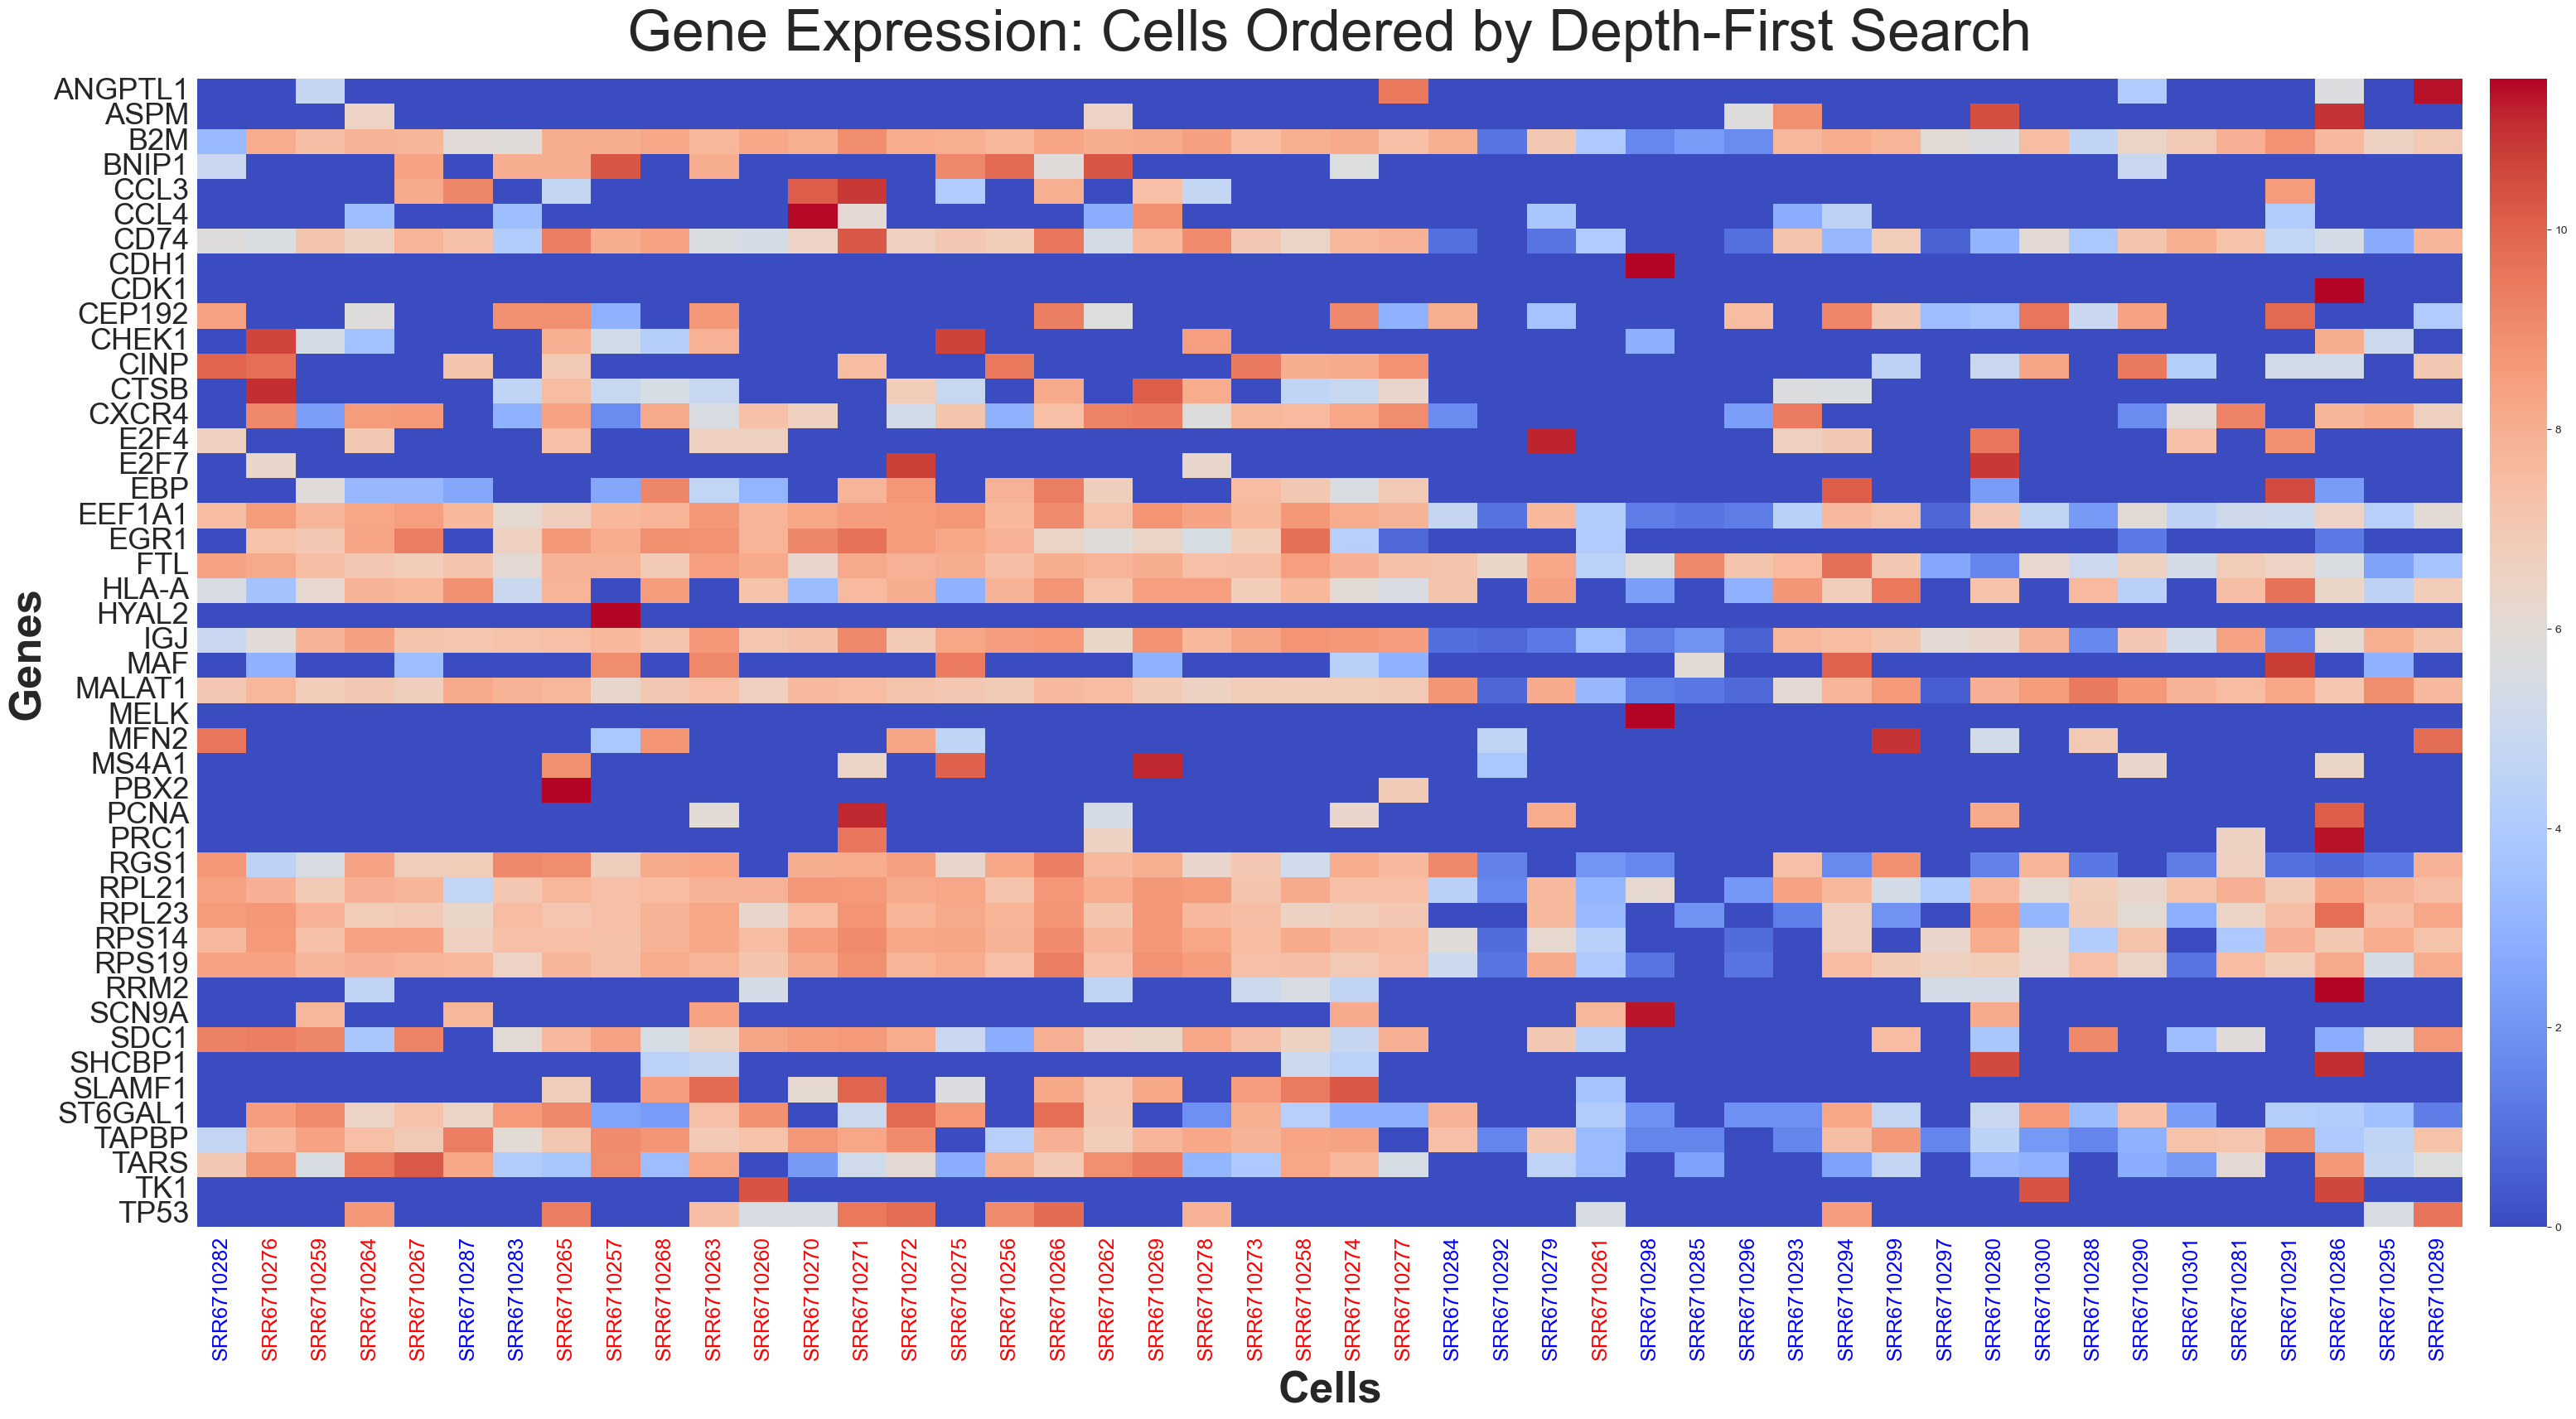

In [48]:
sorted_indices = leaf_order

plt.figure(figsize=(40, 20))

genes = top_expr_genes.index[:10]

if study_num[:2] == "mm":
    genes = ["IGJ", "CTSB", "EGR1", "FTL", "MALAT1", "RPL21", "SDC1", "SLAMF1", "CDH1", "ETV7", "CXCR4", "E2F4", "ANGPTL1", "HYAL2", "PBX2", "SCN9A", "BNIP1", "MFN2", "CEP192", "TARS", "E2F7", "MELK", "CHEK1", "EBP", "CINP", "PCNA", "ASPM", "CDK1", "MAF", "TP53", "MS4A1", "RGS1", "ST6GAL1", "HLA-A", "TAPBP", "CD74", "B2M", "CCL3", "CCL4", "RPS14","RPS19", "RPL23", "EEF1A1", "TK1", "RRM2","SHCBP1", "PRC1"]

chosen_genes = expression_counts_scaled[expression_counts_scaled.index.isin(genes)]
sorted_df = chosen_genes.iloc[:, sorted_indices]

col_colors = ['red' if val in cell_indices else 'blue' for val in sorted_indices]

plt.figure(figsize=(42, 18))
ax = sns.heatmap(sorted_df, cmap='coolwarm', cbar_kws={'pad': 0.01})

for n, tick_label in enumerate(ax.get_xticklabels()):
    tick_label.set_color(col_colors[n])
    tick_label.set_fontsize(18)

for tick_label in ax.get_yticklabels():
    tick_label.set_fontsize(26)
    tick_label.set_rotation(0)

plt.title("Gene Expression: Cells Ordered by Depth-First Search", fontsize=50, pad=25)
plt.ylabel("Genes", fontsize=38, fontweight='bold')
plt.xlabel("Cells", fontsize=38, fontweight='bold', labelpad=10)
plt.savefig(rf"../data/results/figures/gene_expression_{study_num}.svg", format="svg")
plt.show()

In [49]:
n_bootstrap = 1000
path_bootstrap = ""

selected = np.loadtxt(os.path.join(path_bootstrap, "selected.txt"), delimiter=',', dtype=int)
ref = pd.read_csv(os.path.join(f"../data/input_data/{study_num}", "ref.csv"))

all_individual_overdispersions_h = np.full((n_bootstrap, ref.shape[1]), np.nan)
all_individual_dropouts = np.full((n_bootstrap, ref.shape[1]), np.nan)

for i in range(n_bootstrap):
    for j in range(n_rounds-1, n_rounds):
        selected_mutations = np.loadtxt(os.path.join(path_bootstrap, "sciterna_selected_loci", f"sciterna_selected_loci_{j}r{i}.txt"), dtype=int)
        individual_dropouts = np.loadtxt(os.path.join(path_bootstrap, "sciterna_individual_dropout_probs", f"sciterna_individual_dropout_probs_{j}r{i}.txt"))
        individual_overdispersions_h = np.loadtxt(os.path.join(path_bootstrap, "sciterna_individual_overdispersions_h", f"sciterna_individual_overdispersions_h_{j}r{i}.txt"))

        unique_mutations = np.unique(selected_mutations)
        for mut in unique_mutations:
            indices = np.where(selected_mutations == mut)[0]
            mean_dropout = np.mean(individual_dropouts[indices])
            mean_overdispersion = np.mean(individual_overdispersions_h[indices])

            all_individual_dropouts[i, mut] = mean_dropout
            all_individual_overdispersions_h[i, mut] = mean_overdispersion

FileNotFoundError: selected.txt not found.

In [85]:
samples = ["MM16", "MM34"]
global_parameters = {}

for s in samples:
    path_bootstrap = rf"../data/results/{s.lower()}/sciterna_bootstrap"
    global_parameters[s] = []
    for i in range(n_bootstrap):
        for j in range(n_rounds-1, n_rounds):
            global_param = np.loadtxt(os.path.join(path_bootstrap, "sciterna_global_parameters", f"sciterna_global_parameters_{j}r{i}.txt"))
            global_parameters[s].append(global_param)
    global_parameters[s] = np.array(global_parameters[s]) # Dropout, Overdispersion homozygous, Error Rate, Overdispersion heterozygous

In [84]:
# get the individual parameters, that were optimized for each SNV, instead of using the global parameter value

global_parameters_sample = global_parameters[study_num.upper()]

sufficient_data_columns_od = ~np.any(
    all_individual_overdispersions_h == global_parameters_sample[:, 3][:, np.newaxis], axis=0
)

sufficient_data_columns_dropout = ~np.any(
    all_individual_dropouts == global_parameters_sample[:, 0][:, np.newaxis], axis=0
)
mean_overdispersions = np.nanmean(all_individual_overdispersions_h[:, sufficient_data_columns_od], axis=0)
mean_dropouts = np.nanmean(all_individual_dropouts[:, sufficient_data_columns_dropout], axis=0)

C:\Users\Norio\AppData\Local\Temp\ipykernel_36436\1951844210.py:12: RuntimeWarning: Mean of empty slice
  mean_overdispersions = np.nanmean(all_individual_overdispersions_h[:, sufficient_data_columns_od], axis=0)
C:\Users\Norio\AppData\Local\Temp\ipykernel_36436\1951844210.py:13: RuntimeWarning: Mean of empty slice
  mean_dropouts = np.nanmean(all_individual_dropouts[:, sufficient_data_columns_dropout], axis=0)


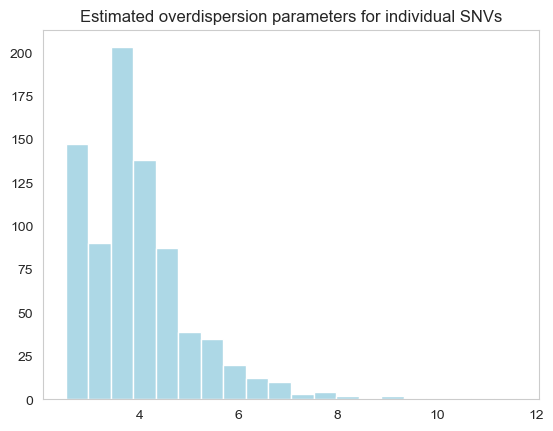

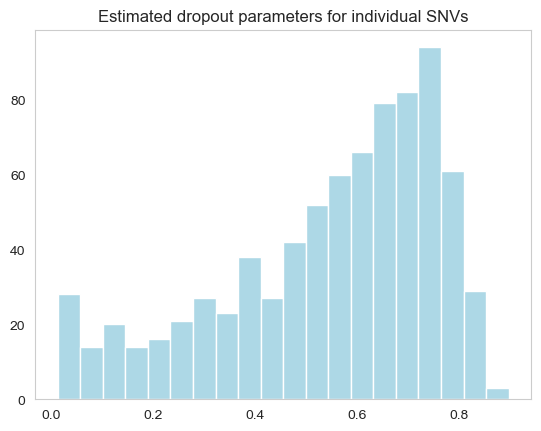

In [86]:
path_bootstrap = rf"../data/results/{study_num}/sciterna_bootstrap"

plt.hist(mean_overdispersions, bins=20, color='lightblue')
plt.title("Estimated overdispersion parameters for individual SNVs")
plt.grid(False)
# plt.savefig(os.path.join(path_bootstrap, "overdispersion_histogram.svg"), format="svg")
plt.show()

plt.hist(mean_dropouts, bins=20, color='lightblue')
plt.title("Estimated dropout parameters for individual SNVs")
plt.grid(False)
# plt.savefig(os.path.join(path_bootstrap, "dropout_histogram.svg"), format="svg")
plt.show()

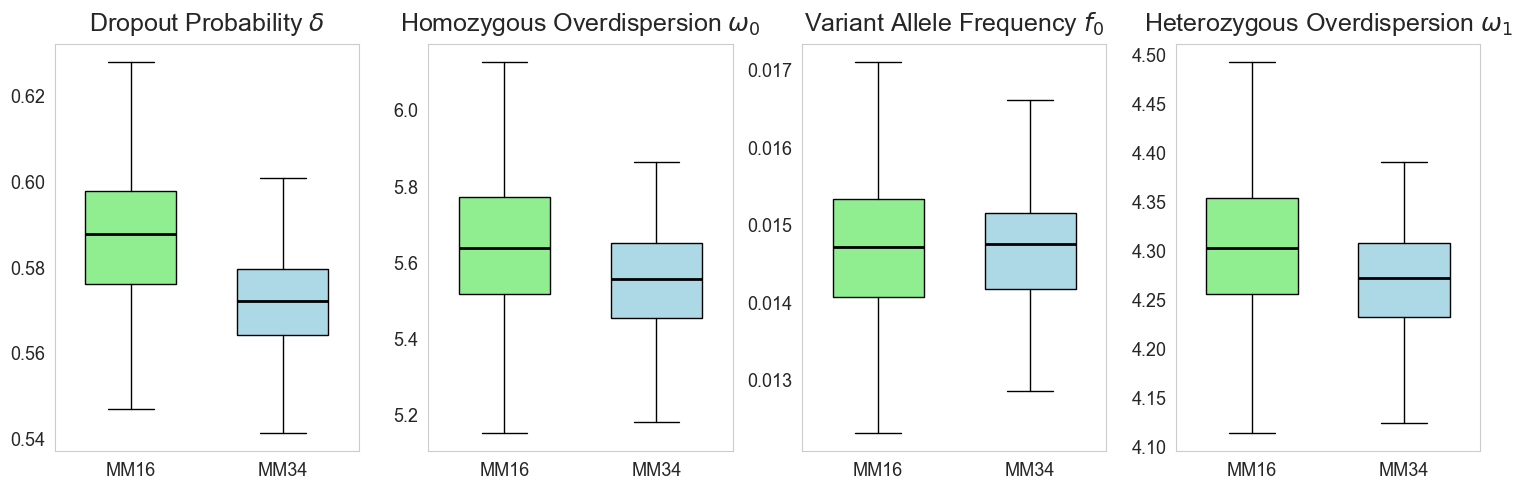

In [40]:
param_names = [r"Dropout Probability $\delta$", r"Homozygous Overdispersion $\omega_\mathrm{0}$", r"Variant Allele Frequency $f_\mathrm{0}$", r"Heterozygous Overdispersion $\omega_\mathrm{1}$"]

for s in samples:
    global_parameters[s] = np.array(global_parameters[s])

# Plotting
fig, axes = plt.subplots(1, 4, figsize=(15, 5))
box_colors = ['lightgreen', 'lightblue', 'lightcoral', 'khaki']

for idx, param_name in enumerate(param_names):
    # Collect values for this parameter across all samples
    data = [global_parameters[s][:, idx] for s in samples]
    bplot = axes[idx].boxplot(data, patch_artist=True, labels=samples, showfliers=False, widths=0.6)

    # Color each box
    for patch, color in zip(bplot['boxes'], box_colors):
        patch.set_facecolor(color)
        patch.set_edgecolor('black')

    for median in bplot['medians']:
        median.set_color('black')
        median.set_linewidth(2)

    axes[idx].set_title(param_name, fontsize=18, pad=10)
    axes[idx].set_ylabel(f"", fontsize=14)
    axes[idx].tick_params(axis='x', labelsize=13)
    axes[idx].tick_params(axis='y', labelsize=13)
    axes[idx].grid(False)

plt.tight_layout()
# plt.savefig(r"C:\Users\Norio\Documents\GitHub\SCITE-RNA-v2\data\results\figures\global_parameters.pdf", format="pdf")
plt.show()

In [41]:
selected_loci = np.loadtxt(rf"../data/results/{study_num}/sciterna_bootstrap/selected.txt", dtype=int)

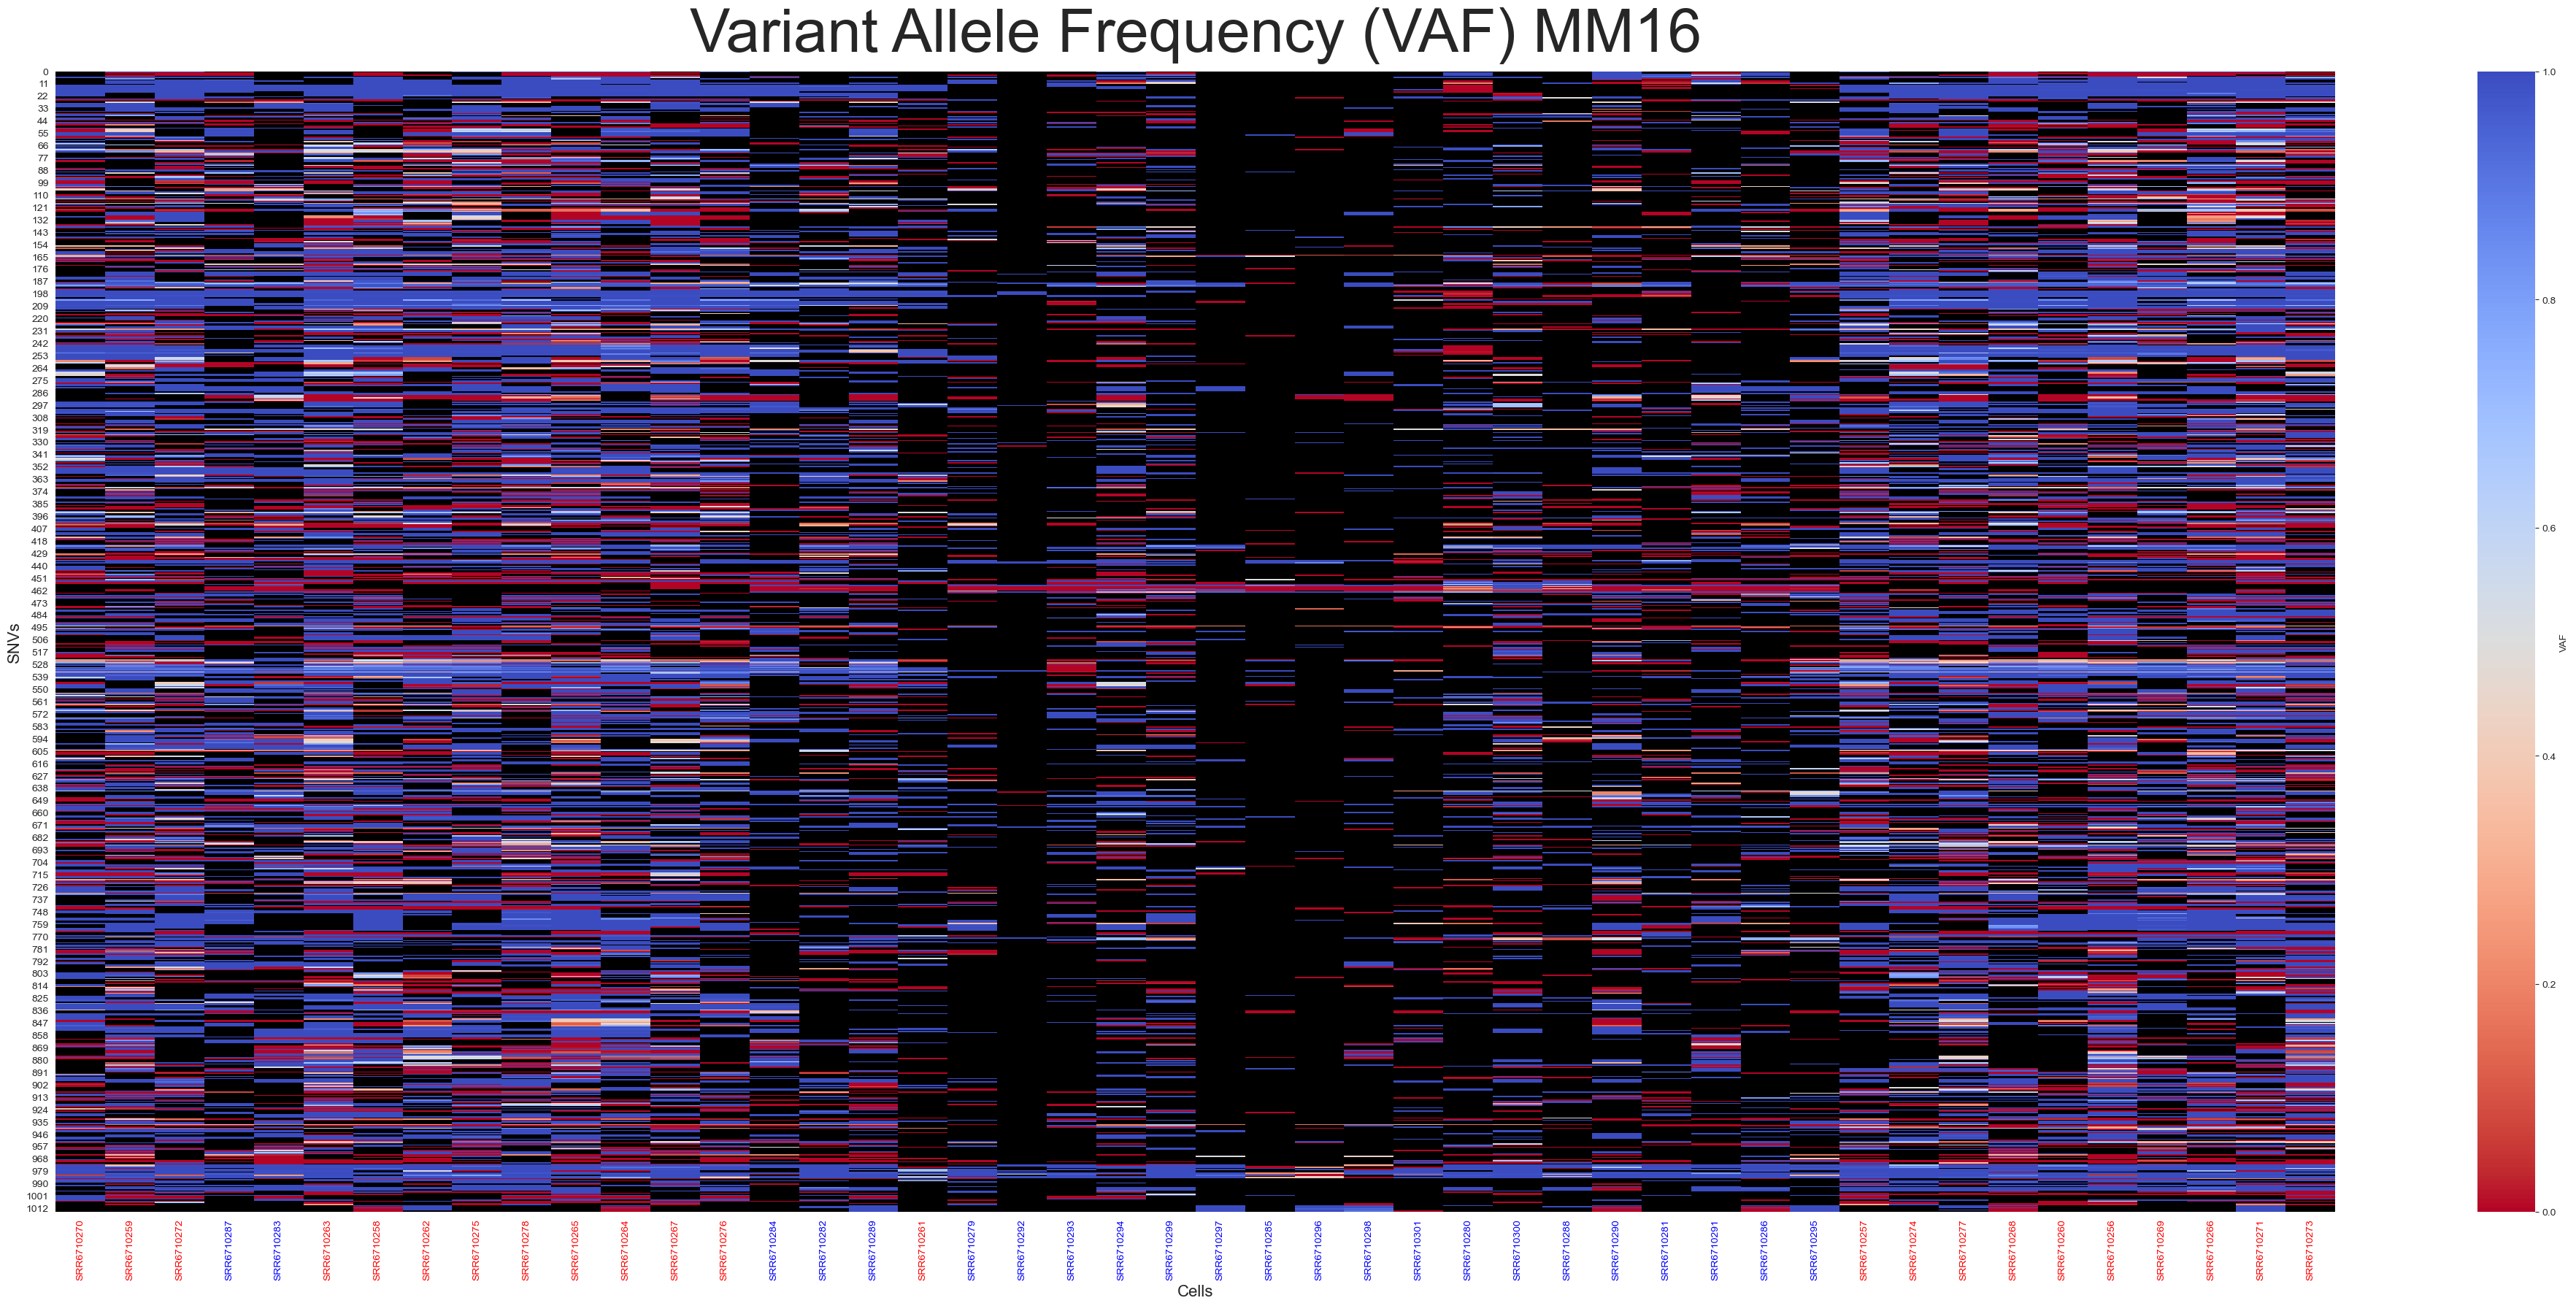

In [42]:
ref = np.array(pd.read_csv(os.path.join(f"../data/input_data/{study_num}", "ref.csv")))[:, 1:].astype(int)
alt = np.array(pd.read_csv(os.path.join(f"../data/input_data/{study_num}", "alt.csv")))[:, 1:].astype(int)

with np.errstate(divide='ignore', invalid='ignore'):
    vaf = alt[:,selected_loci] / (ref[:,selected_loci] + alt[:,selected_loci])

vaf = vaf[leaf_order].T  # Transpose for plotting (SNVs as rows)

# Define colormap: black for NaN, color gradient for valid values
base_cmap = plt.get_cmap("coolwarm_r")  # Or 'coolwarm', 'RdYlBu'
cmap_with_nan = base_cmap
cmap_with_nan.set_bad(color='black')

plt.figure(figsize=(40, 18))
ax = sns.heatmap(
    vaf,
    cmap=cmap_with_nan,
    vmin=0,
    vmax=1,
    cbar_kws={"label": "VAF"}
)
plt.title(f"Variant Allele Frequency (VAF) {study_num.upper()}", fontsize=60, pad=20)
plt.ylabel("SNVs", fontsize=16)
plt.xlabel("Cells", fontsize=16)

# Set x-axis tick label colors
ax.set_xticks(np.arange(len(leaf_order)) + 0.5)
ax.set_xticklabels(sorted_df.columns, rotation=90)
for n, tick_label in enumerate(ax.get_xticklabels()):
    tick_label.set_color(col_colors[n])

plt.tight_layout()
# plt.savefig(rf"../data/results/{study_num}/sciterna_bootstrap/vaf.png", format="png")
plt.show()

Finally we aim to find the genes with the most mutations

In [26]:
# with open("../data/input_data/gencode.v21.annotation.gtf", 'r') as file:
#     for line in file:
#         if line.startswith("#"):
#                 continue
#         fields = line.strip().split('\t')
#         if fields[2] == 'gene':
#             attributes = {key_value.split(' ')[0]: key_value.split(' ')[1].strip('"') for key_value in
#                           fields[8].split('; ') if key_value}
#             gene_names.append([fields[0], fields[3], fields[4], attributes["gene_name"]])
#
# df = pd.DataFrame(gene_names, columns=['chromosome', 'start', 'end', 'gene'])
# df['start'] = df['start'].astype(int)
# df['end'] = df['end'].astype(int)
# df.to_csv("../data/input_data/mm34/gene_positions.csv", index=False)

def convert_location_to_gene(locs):

    loc_to_gene = []

    df = pd.read_csv("../data/input_data/mm34/gene_positions.csv", index_col=False)
    for location in locs:
        chrom, pos = location.split(":")[0], location.split(":")[1]
        pos = int(pos)
        matching_rows = df[(df['chromosome'] == chrom) & (df['start'] <= pos) & (df['end'] >= pos)]
        matching_genes = matching_rows['gene'].tolist()
        loc_to_gene.append(matching_genes)

    return loc_to_gene

In [27]:
ref = pd.read_csv(os.path.join(f"../data/input_data/{study_num}", "ref.csv"))
selected_loci_pos = ref.columns[selected_loci][1:]
selected_genes = convert_location_to_gene(selected_loci_pos)

In [28]:
genes = []
for s in selected_genes:
    genes.extend(s)
gens, cnt = np.unique(genes, return_counts=True)

print(cnt[np.argsort(cnt)][-30:])
print(gens[np.argsort(cnt)][-30:])

[ 5  5  5  5  5  5  5  5  5  5  5  6  6  6  6  6  6  7  7  7  8  8  8  8
  9 10 13 14 18 47]
['IGHV4-34' 'RP5-857K21.4' 'VAMP8' 'SERPINB9' 'CD38' 'MCTP2' 'MALAT1'
 'ELL' 'COA1' 'PHACTR1' 'IFRD1' 'IGHV1-2' 'UBE2H' 'HLA-B' 'HCLS1' 'IGKC'
 'HLA-C' 'SLC35F2' 'SSR3' 'ANKRD28' 'NAMPT' 'IGHG3' 'MIR29B1' 'HLA-A'
 'IGHM' 'CNTN5' 'FNDC3B' 'AC016831.7' 'IGHG1' 'LINC-PINT']
